#  Определение паттернов номеров, наиболее вероятно относящихся к Flash Call, используемых при регистрации в приложении Viber

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Поменяю названия столбцов на более удобные:

In [2]:
data = pd.read_excel('viber.xlsx', sheet_name='data')
data.columns = ['anumber', 'cnt']

После первой попытки неудачной верификации, второй и последующие вызовы приходят уже с других номеров.  
Поэтому уберу строки с полем **cnt > 1**:

In [3]:
data_1_call = data.query('cnt == 1').copy(deep=True).reset_index(drop=True)

Добавлю три новых столбца, содержащих цифры из поля с полным номером А: **prefix**(цифры 1-4), **code**(цифры 5-10), **suffix**(цифры 11 и 12):

In [4]:
data_1_call['prefix'] = data_1_call['anumber'].apply(lambda x: str(x)[:4])
data_1_call['code'] = data_1_call['anumber'].apply(lambda x: str(x)[4:10])
data_1_call['suffix'] = data_1_call['anumber'].apply(lambda x: str(x)[10:])
data_1_call.head()

,anumber,cnt,prefix,code,suffix
0,332412996289,1,3324,129962,89
1,332414582798,1,3324,145827,98
2,332414919598,1,3324,149195,98
3,332419111298,1,3324,191112,98
4,332420553298,1,3324,205532,98


Сгруппирую таблицу по кодам и посчитаю количество их появления:

In [5]:
codes_cnt = data_1_call.groupby('code')['anumber'].count().sort_values(ascending=False)
codes_cnt.head(10)

code
753815    3
407079    2
185274    2
725999    2
894583    2
598020    2
897976    2
763744    2
140728    2
763459    2
Name: anumber, dtype: int64

Имеются много кодов, которые отправлялись 2-3 раза. Это соответствует политике Viber - для каждого пользователя доступны 3 попытки верификации подряд. Затем бан на 24 часа. Пусть это будут первые кандидаты на звонки от Viber: 

In [6]:
#Набор кодов с повторениями
mfreq_codes = codes_cnt[(codes_cnt > 1) & (codes_cnt <= 3)]
#Записи вызовов с этими кодами:
viber_short_list = data_1_call.query('code in @mfreq_codes.index')
viber_short_list.head()

,anumber,cnt,prefix,code,suffix
41,332515394388,1,3325,153943,88
69,332592549379,1,3325,925493,79
94,332663914887,1,3326,639148,87
134,332775381559,1,3327,753815,59
154,332834733785,1,3328,347337,85


Получилось столько записей о звонках с повторяющейся 2 или 3 раза только кодовой частью:

In [7]:
viber_short_list.shape[0]

83

Это будет короткий список предполагаемых вызовов от Viber.   
Для получения длинного списка отфильтрую оригинальную таблицу с одиночными вызовами по значемиям префиксов из узкого списка:

In [8]:
viber_long_list = data_1_call.query('prefix in @viber_short_list.prefix')

Его размер:

In [9]:
viber_long_list.shape[0]

2002

Итоговые гистограммы вызовов с префиксов, по звонкам с которых замечено повторение кодовой части номера А:

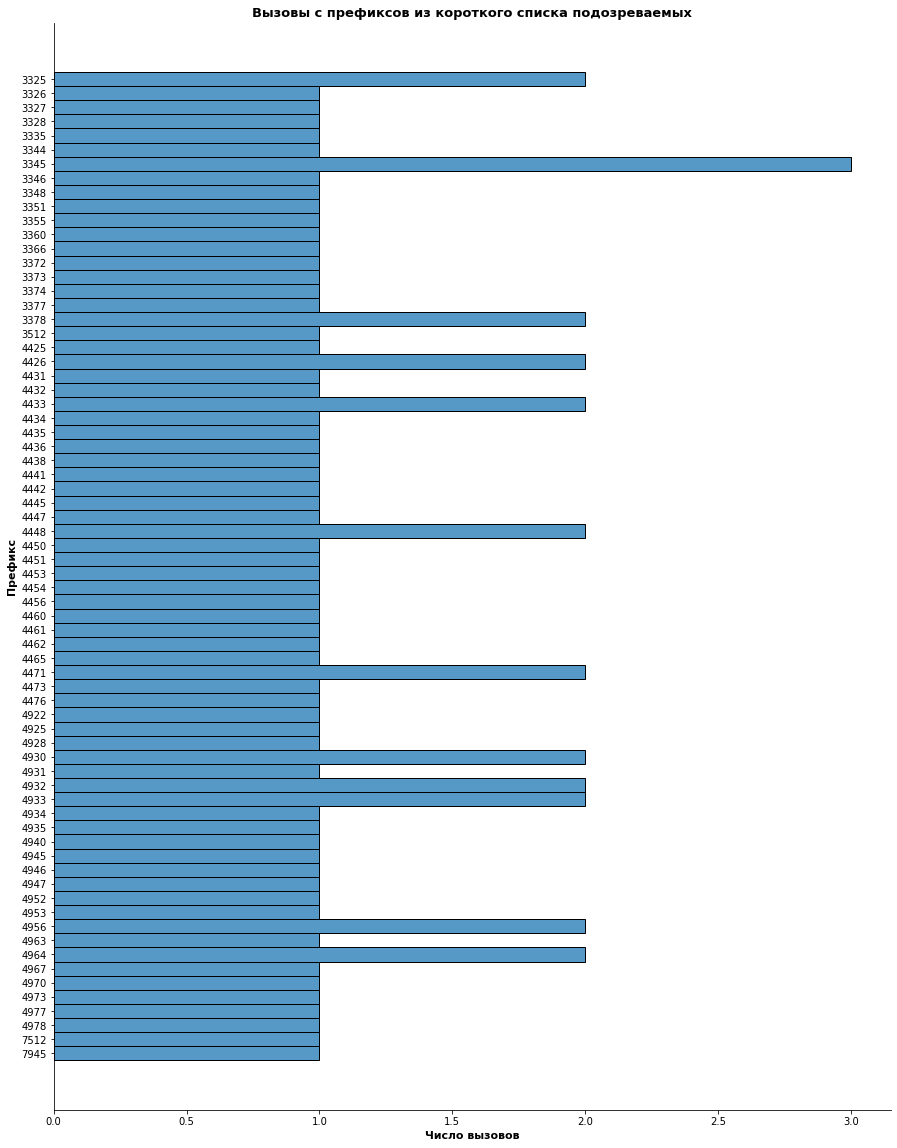

In [10]:
plt.figure(figsize=(15,20))
ax = sns.histplot(data=viber_short_list, y='prefix')
ax.set_title('Вызовы с префиксов из короткого списка подозреваемых',
                 fontdict={'fontsize': 13, 'fontweight': 'bold'})
ax.set_xlabel('Число вызовов', fontdict={'fontsize': 11, 'fontweight': 'bold'})
ax.set_ylabel('Префикс', fontdict={'fontsize': 11, 'fontweight': 'bold'})
sns.despine()

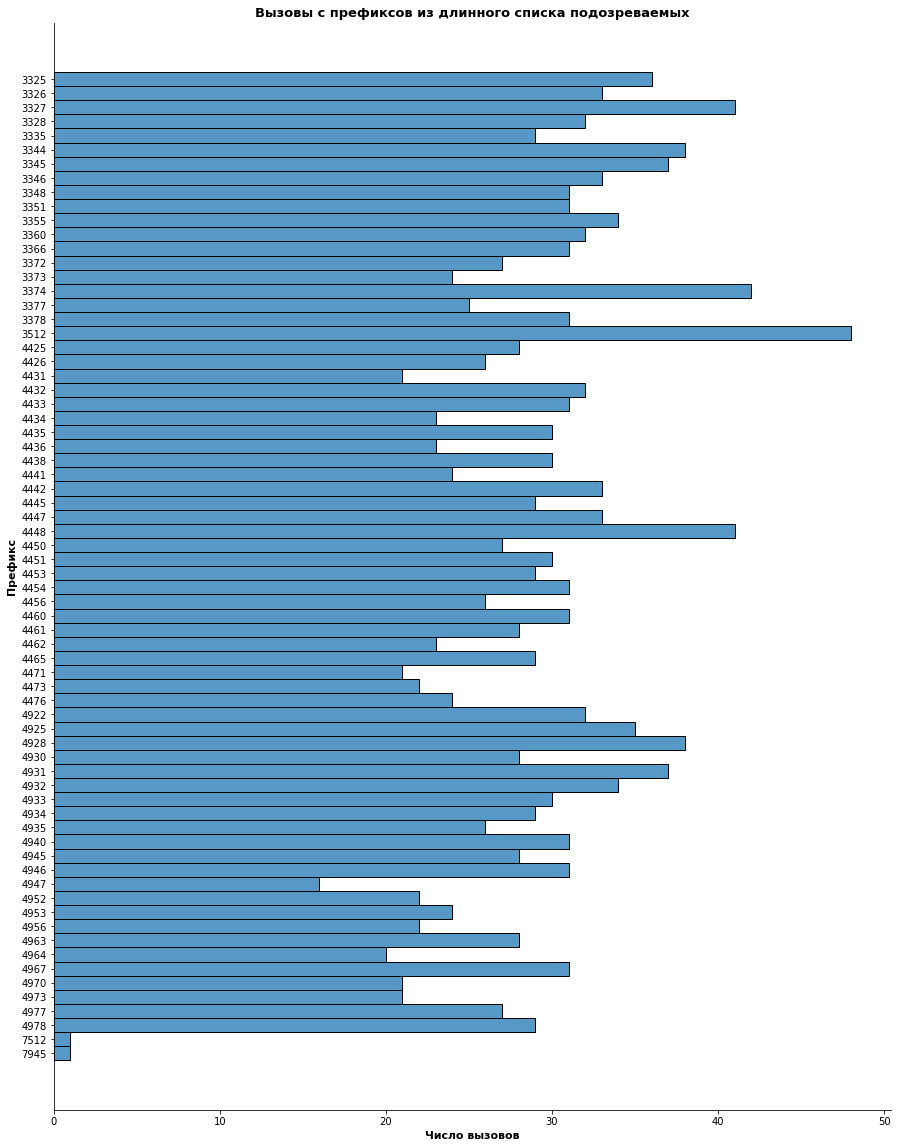

In [11]:
plt.figure(figsize=(15,20))
ax = sns.histplot(data=viber_long_list, y='prefix')
ax.set_title('Вызовы с префиксов из длинного списка подозреваемых',
                 fontdict={'fontsize': 13, 'fontweight': 'bold'})
ax.set_xlabel('Число вызовов', fontdict={'fontsize': 11, 'fontweight': 'bold'})
ax.set_ylabel('Префикс', fontdict={'fontsize': 11, 'fontweight': 'bold'})
sns.despine()

Почти вся информация относится к трем странам: Франция(код 33), Великобритания(код 49) и Германия(код 49).  
Это соотносится с моим личным опытом: из трех попыток верификации вызов дважды приходил из Германии и один раз из Франции.

## Резюме:

Вероятнее всего вызовы от Viber происходили с префиксов, отображенных на гистограммах.

## Замечание:
Для более точных выводов были бы полезны временные метки вызовов и номера Б.   
Можно было сделать дополнительные выводы по интервалам между вызовами с одинаковой кодовой частью и по значениям номера Б в них.